In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import Ridge

---

In [5]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 
              'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 
              'view':int}

---

Write your own function called ‘polynomial_sframe’ (or otherwise) which accepts an array ‘feature’ and a maximal ‘degree’ and returns an data frame (e.g. SFrame) with the first column equal to ‘feature’ and the remaining columns equal to ‘feature’ to increasing integer powers up to ‘degree’.

In [6]:
def polynomial_dataframe(feature, degree): # feature is pandas.Series type
    # assume that degree >= 1
    # initialize the dataframe:
    poly_dataframe = pd.DataFrame()
    # and set poly_dataframe['power_1'] equal to the passed feature
    poly_dataframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        for power in range(2, degree+1):
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # assign poly_dataframe[name] to be feature^power; use apply(*)
            poly_dataframe[name] = feature.apply(lambda x: x**power)
    return poly_dataframe

---

For the remainder of the assignment we will be working with the house Sales data as in the previous notebooks. Load in the data and also sort the sales SFrame by ‘sqft_living’. When we plot the fitted values we want to join them up in a line and this works best if the variable on the X-axis (which will be ‘sqft_living’) is sorted. For houses with identical square footage, we break the tie by their prices.

In [7]:
sales = pd.read_csv('./data/kc_house_data.csv', dtype=dtype_dict, index_col=0)
sales = sales.sort_values(['sqft_living','price'])

In [8]:
train_data = pd.read_csv('./data/kc_house_train_data.csv', dtype=dtype_dict, index_col=0)
test_data = pd.read_csv('./data/kc_house_test_data.csv', dtype=dtype_dict, index_col=0)

---

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_sframe()` and fit a model with these features. When fitting the model, use an L2 penalty of 1.5e-5.

In [9]:
l2_small_penalty = 1.5e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results. Thus, rather than using no regularization, we will introduce a tiny amount of regularization (l2_penalty=1.5e-5) to make the solution numerically stable. (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights. Add "alpha=l2_small_penalty" and "normalize=True" to the parameter list of linear_model.Ridge:

In [10]:
poly15_data = polynomial_dataframe(sales['sqft_living'], 15)
model = Ridge(alpha=l2_small_penalty, normalize=True).fit(poly15_data, sales.price)

In [11]:
model.coef_

array([ 1.24873306e+02, -4.77376011e-02,  3.01446238e-05, -2.44419942e-09,
       -1.94153675e-13,  8.54085686e-18,  1.51142121e-21,  8.27979094e-26,
        6.52603100e-31, -3.27895017e-34, -3.87962315e-38, -2.72437650e-42,
       -1.07790800e-46,  3.78242694e-51,  1.39790296e-54])

---

# Observe Overfitting

Recall from Module 3 (Polynomial Regression) that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a high variance. We will see in a moment that ridge regression reduces such variance. But first, we must reproduce the experiment we did in Module 3.

For this section, please download the provided csv files for each subset and load them with the given list of types:

In [12]:
set_1 = pd.read_csv('./data/wk3_kc_house_set_1_data.csv', dtype=dtype_dict)
set_2 = pd.read_csv('./data/wk3_kc_house_set_2_data.csv', dtype=dtype_dict)
set_3 = pd.read_csv('./data/wk3_kc_house_set_3_data.csv', dtype=dtype_dict)
set_4 = pd.read_csv('./data/wk3_kc_house_set_4_data.csv', dtype=dtype_dict)

Just as we did in Module 3 (Polynomial Regression), fit a 15th degree polynomial on each of the 4 sets, plot the results and view the weights for the four models. This time, set

In [13]:
l2_small_penalty=1e-9

and use this value for the L2 penalty. Make sure to add "alpha=l2_small_penalty" and "normalize=True" to the parameter list of linear_model.Ridge.

In [14]:
def poly_ridge_reg(feature, y, degree, l2_penalty):
    poly_data = polynomial_dataframe(feature, degree)
    poly_data['price'] = y
    end_col = 'power_' + str(degree)
    model = Ridge(alpha=l2_penalty, normalize=True).fit(X=poly_data.loc[:,'power_1':end_col], 
                                                        y=poly_data.price)
    print(model.coef_, model.intercept_)
    plt.plot(poly_data['power_1'], poly_data['price'],'.',
             poly_data['power_1'], model.predict(poly_data.loc[:,'power_1':end_col]),'-')

[ 5.44669399e+02 -3.55447605e-01  1.22446380e-04 -1.17175307e-08
 -3.90512698e-13 -1.39075911e-17  1.47860283e-20  6.87491630e-25
 -7.57203971e-29 -1.04097276e-32 -3.71844269e-37  3.39989255e-41
  5.56592051e-45  2.53761389e-49 -3.35152915e-53] 23888.82535718009


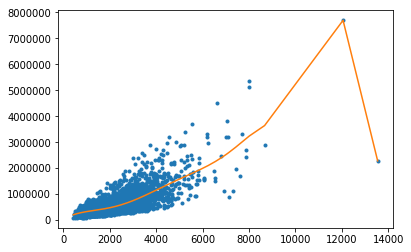

In [15]:
poly_ridge_reg(set_1.sqft_living, set_1.price, 15, l2_small_penalty)

[ 8.59362651e+02 -8.18118278e-01  4.28879983e-04 -9.12770660e-08
 -2.69604404e-12  3.73980300e-15 -1.42711882e-19 -6.30794703e-23
 -1.44559628e-27  7.44321353e-31  9.25865883e-35  3.28010483e-41
 -1.29543508e-42 -1.38781255e-46  1.66546444e-50] -55614.64099733415


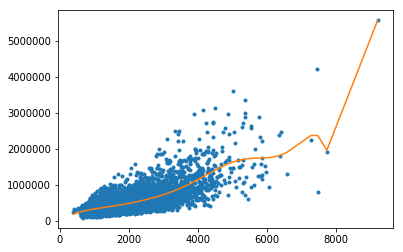

In [16]:
poly_ridge_reg(set_2.sqft_living, set_2.price, 15, l2_small_penalty)

[-7.55395963e+02  9.75579541e-01 -4.58946006e-04  7.77958113e-08
  7.15013417e-12 -2.88602002e-15 -2.13677720e-20  3.38085194e-23
  2.19178226e-27 -1.97067793e-31 -4.15993202e-35 -1.80196143e-39
  3.19071198e-43  5.08456859e-47 -3.93304243e-51] 470987.87434957223


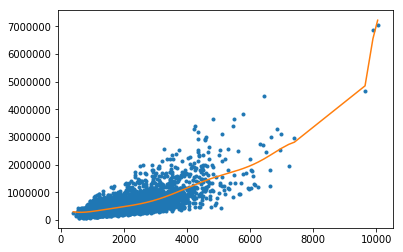

In [17]:
poly_ridge_reg(set_3.sqft_living, set_3.price, 15, l2_small_penalty)

[ 1.11944571e+03 -9.83760212e-01  3.38770897e-04  3.60377209e-08
 -4.37814017e-11  5.77191690e-15  7.66795221e-19 -9.49297664e-23
 -1.96030821e-26 -2.10880282e-32  3.31005065e-34  3.47733891e-38
 -2.43039323e-42 -8.79553219e-46  6.44569659e-50] -145655.6184999908


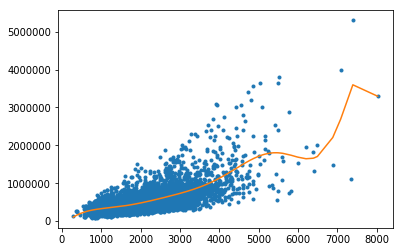

In [18]:
poly_ridge_reg(set_4.sqft_living, set_4.price, 15, l2_small_penalty)

The four curves should differ from one another a lot, as should the coefficients you learned.

---

# Ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (The weights looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

Fit a 15th-order polynomial model on set_1, set_2, set_3, and set_4, this time with a large L2 penalty. Make sure to add "alpha=l2_large_penalty" and "normalize=True" to the parameter list, where the value of l2_large_penalty is given by

In [19]:
l2_large_penalty=1.23e2

These curves should vary a lot less, now that you introduced regularization.

[2.32806803e+00 3.53621608e-04 3.31969692e-08 2.00082477e-12
 1.11492559e-16 6.57786122e-21 4.12939525e-25 2.70393755e-29
 1.81614763e-33 1.23824277e-37 8.51872481e-42 5.89455598e-46
 4.09542560e-50 2.85464889e-54 1.99547476e-58] 539103.0310577955


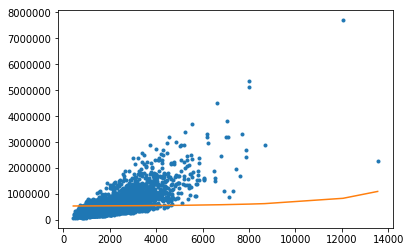

In [20]:
poly_ridge_reg(set_1.sqft_living, set_1.price, 15, l2_large_penalty)

[2.09756903e+00 3.90817483e-04 6.67189944e-08 8.90002997e-12
 9.72639877e-16 9.69733682e-20 9.50564475e-24 9.44491031e-28
 9.57191338e-32 9.86945155e-36 1.03101115e-39 1.08729784e-43
 1.15453748e-47 1.23211305e-51 1.31986696e-55] 529853.0253577976


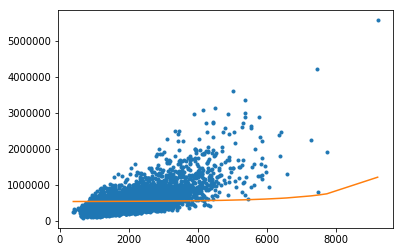

In [21]:
poly_ridge_reg(set_2.sqft_living, set_2.price, 15, l2_large_penalty)

[2.28906258e+00 4.12472190e-04 6.08835345e-08 6.58572163e-12
 6.15278155e-16 5.64446634e-20 5.28834396e-24 5.07091402e-28
 4.94657273e-32 4.88043809e-36 4.85009106e-40 4.84161534e-44
 4.84635021e-48 4.85883628e-52 4.87558469e-56] 533640.1140974432


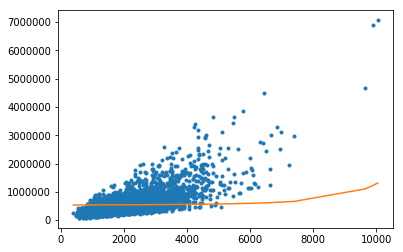

In [22]:
poly_ridge_reg(set_3.sqft_living, set_3.price, 15, l2_large_penalty)

[2.08596194e+00 4.05035772e-04 7.46864647e-08 1.13096608e-11
 1.45864442e-15 1.73561251e-19 2.01609632e-23 2.34605255e-27
 2.75636073e-31 3.27043069e-35 3.91046855e-39 4.70118041e-43
 5.67212304e-47 6.85958087e-51 8.30843630e-55] 524562.9690466832


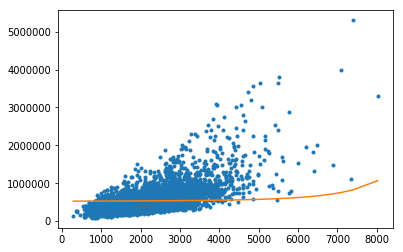

In [23]:
poly_ridge_reg(set_4.sqft_living, set_4.price, 15, l2_large_penalty)

---

# Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. Cross-validation seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called k-fold cross-validation. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

- Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set
- Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set
- ...
- Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that all observations are used for both training and validation, as we iterate over segments of data.

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. We reserve 10% of the data as the test set and randomly shuffle the remainder. Le'ts call the shuffled data 'train_valid_shuffled'. In practice, you would shuffle the rows with a dynamically determined random seed.

In [24]:
train_valid_shuffled = pd.read_csv('./data/wk3_kc_house_train_valid_shuffled.csv', dtype=dtype_dict)
test = pd.read_csv('./data/wk3_kc_house_test_data.csv', dtype=dtype_dict)

In [25]:
poly15_shuffled_data = polynomial_dataframe(train_valid_shuffled['sqft_living'], 15)
poly15_test_data = polynomial_dataframe(test['sqft_living'], 15)

Divide the combined training and validation set into equal segments. Each segment should receive n/k elements, where n is the number of observations in the training set and k is the number of segments. Since the segment 0 starts at index 0 and contains n/k elements, it ends at index (n/k)-1. The segment 1 starts where the segment 0 left off, at index (n/k). With n/k elements, the segment 1 ends at index (n\*2/k)-1. Continuing in this fashion, we deduce that the segment i starts at index (n\*i/k) and ends at (n\*(i+1)/k)-1.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [26]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in range(k):
    start = np.floor((n*i)/k).astype(int)
    end = np.floor((n*(i+1))/k).astype(int)
    print (i, (start, end))

0 (0, 1939)
1 (1939, 3879)
2 (3879, 5818)
3 (5818, 7758)
4 (7758, 9698)
5 (9698, 11637)
6 (11637, 13577)
7 (13577, 15516)
8 (15516, 17456)
9 (17456, 19396)


Let us familiarize ourselves with array slicing with Pandas. To extract a continuous slice from a DataFrame, use colon in square brackets. For instance, the following cell extracts rows 0 to 9 of train_valid_shuffled. Notice that the first index (0) is included in the slice but the last index (10) is omitted.

In [27]:
train_valid_shuffled[0:10] # select rows 0 to 9

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2780400035,20140505T000000,665000.0,4.0,2.50,2800.0,5900,1,0,0,...,8,1660,1140,1963,0,98115,47.6809,-122.286,2580.0,5900.0
1,1703050500,20150321T000000,645000.0,3.0,2.50,2490.0,5978,2,0,0,...,9,2490,0,2003,0,98074,47.6298,-122.022,2710.0,6629.0
2,5700002325,20140605T000000,640000.0,3.0,1.75,2340.0,4206,1,0,0,...,7,1170,1170,1917,0,98144,47.5759,-122.288,1360.0,4725.0
3,0475000510,20141118T000000,594000.0,3.0,1.00,1320.0,5000,1,0,0,...,7,1090,230,1920,0,98107,47.6674,-122.365,1700.0,5000.0
4,0844001052,20150128T000000,365000.0,4.0,2.50,1904.0,8200,2,0,0,...,7,1904,0,1999,0,98010,47.3107,-122.001,1560.0,12426.0
5,2781280290,20150427T000000,305000.0,3.0,2.50,1610.0,3516,2,0,0,...,8,1610,0,2006,0,98055,47.4491,-122.188,1610.0,3056.0
6,2214800630,20141105T000000,239950.0,3.0,2.25,1560.0,8280,2,0,0,...,7,1560,0,1979,0,98001,47.3393,-122.259,1920.0,8120.0
7,2114700540,20141021T000000,366000.0,3.0,2.50,1320.0,4320,1,0,0,...,6,660,660,1918,0,98106,47.5327,-122.347,1190.0,4200.0
8,2596400050,20140730T000000,375000.0,3.0,1.00,1960.0,7955,1,0,0,...,7,1260,700,1963,0,98177,47.7641,-122.364,1850.0,8219.0
9,4140900050,20150126T000000,440000.0,4.0,1.75,2180.0,10200,1,0,2,...,8,2000,180,1966,0,98028,47.7638,-122.270,2590.0,10445.0


Now we are ready to implement k-fold cross-validation. Write a function that computes k validation errors by designating each of the k segments as the validation set. It accepts as parameters (i) k, (ii) l2_penalty, (iii) dataframe containing input features (e.g. poly15_data) and (iv) column of output values (e.g. price). The function returns the average validation error using k segments as validation sets. We shall assume that the input dataframe does not contain the output column.

For each i in \[0, 1, ... k-1\]:

- Compute starting and ending indices of segment i and call 'start' and 'end'
- Form validation set by taking a slice (start:end+1) from the data.
- Form training set by appending slice (end+1:n) to the end of slice (0:start).
- Train a linear model using training set just formed, with a given l2_penalty
- Compute validation error (RSS) using validation set just formed

In [28]:
def k_fold_cross_validation(k, l2_penalty, data, output):
    n = data.shape[0]
    RSSs = np.zeros(k)
    for i in range(k):
        start = np.floor((n*i)/k).astype(int)
        end   = np.floor((n*(i+1))/k).astype(int)
        df_Va = data[start:end]
        y_Va  = output[start:end]
        df_Tr = data[0:start].append(data[end:])
        y_Tr  = output[0:start].append(output[end:])
        model = Ridge(alpha=l2_penalty, normalize=True).fit(X=df_Tr, y=y_Tr)
        yhat  = model.predict(df_Va)
        RSSs[i] = np.sum((y_Va.values - yhat)**2)
    return np.mean(RSSs)

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:

- We will again be aiming to fit a 15th-order polynomial model using the sqft_living input
- For each l2_penalty in \[10^3, 10^3.5, 10^4, 10^4.5, ..., 10^9\] (to get this in Python, you can use this Numpy function: np.logspace(3, 9, num=13).): Run 10-fold cross-validation with l2_penalty.
- Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use train_valid_shuffled when generating polynomial features!

In [29]:
l2_penalty_values = np.logspace(3, 9, num=13)

In [30]:
CVs = np.zeros_like(l2_penalty_values)
for i, l2_penalty in enumerate(l2_penalty_values):
    CVs[i] = k_fold_cross_validation(10, l2_penalty, 
                                     poly15_shuffled_data, train_valid_shuffled.price)

In [31]:
l2_penalty_cv = l2_penalty_values[np.argmin(CVs)]
l2_penalty_cv

1000.0

Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of l2_penalty. This way, your final model will be trained on the entire dataset.

In [32]:
model_cv = Ridge(alpha=l2_penalty_cv, normalize=True).fit(X=poly15_shuffled_data, 
                                                          y=train_valid_shuffled.price)
yhat = model_cv.predict(poly15_test_data)

In [33]:
RSS_cv = np.sum((test.price.values - yhat)**2)
print('{:.2e}'.format(RSS_cv))

2.84e+14


[2.79732425e-01 4.92115822e-05 6.26475824e-09 4.62828451e-13
 2.62785732e-17 1.46272531e-21 8.53767142e-26 5.22841848e-30
 3.32023205e-34 2.16418991e-38 1.43774612e-42 9.68946091e-47
 6.60375562e-51 4.54174256e-55 3.14723665e-59] 539117.0722346373


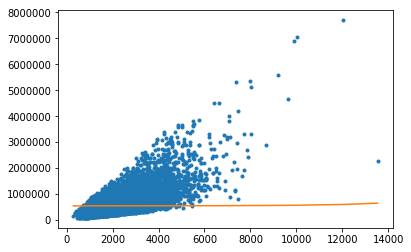

In [34]:
poly_ridge_reg(sales.sqft_living, sales.price, 15, l2_penalty_cv)

---

# Implementing ridge regression via gradient descent

Next, from Module 2, copy and paste the ‘get_numpy_data’ function (or equivalent) that takes a dataframe, a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), to be used as inputs, and a name of the output (e.g. ‘price’). This function returns a ‘feature_matrix’ (2D array) consisting of first a column of ones followed by columns containing the values of the input features in the data set in the same order as the input list. It alsos return an ‘output_array’ which is an array of the values of the output in the data set (e.g. ‘price’).

In [35]:
def get_numpy_data(df, features, output):
    df['constant'] = 1 # add a constant column to an DataFrame
    features = ['constant'] + features
    df_features = df.loc[:, features]
    features_matrix = df_features.values
    output_array = df.loc[:, output].values
    return features_matrix, output_array

Similarly, copy and paste the ‘predict_output’ function (or equivalent) from Module 2. This function accepts a 2D array ‘feature_matrix’ and a 1D array ‘weights’ and return a 1D array ‘predictions’.

In [36]:
def predict_outcome(feature_matrix, weights):
    predictions = feature_matrix @ weights
    return predictions

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```
Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Module 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w\[i\] can be written as:
```
2*SUM[ error*[feature_i] ]
```
The derivative of the regularization term with respect to w\[i\] is:
```
2*l2_penalty*w[i]
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i]
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus 2\*l2_penalty\*w\[i\].

IMPORTANT: We will not regularize the constant. Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2\*l2_penalty\*w\[0\] term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus 2\*l2_penalty\*w\[i\].

With this in mind write the derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points). To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call ‘feature_is_constant’ which you should set to True when computing the derivative of the constant and False otherwise.

In [ ]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    
    return derivative